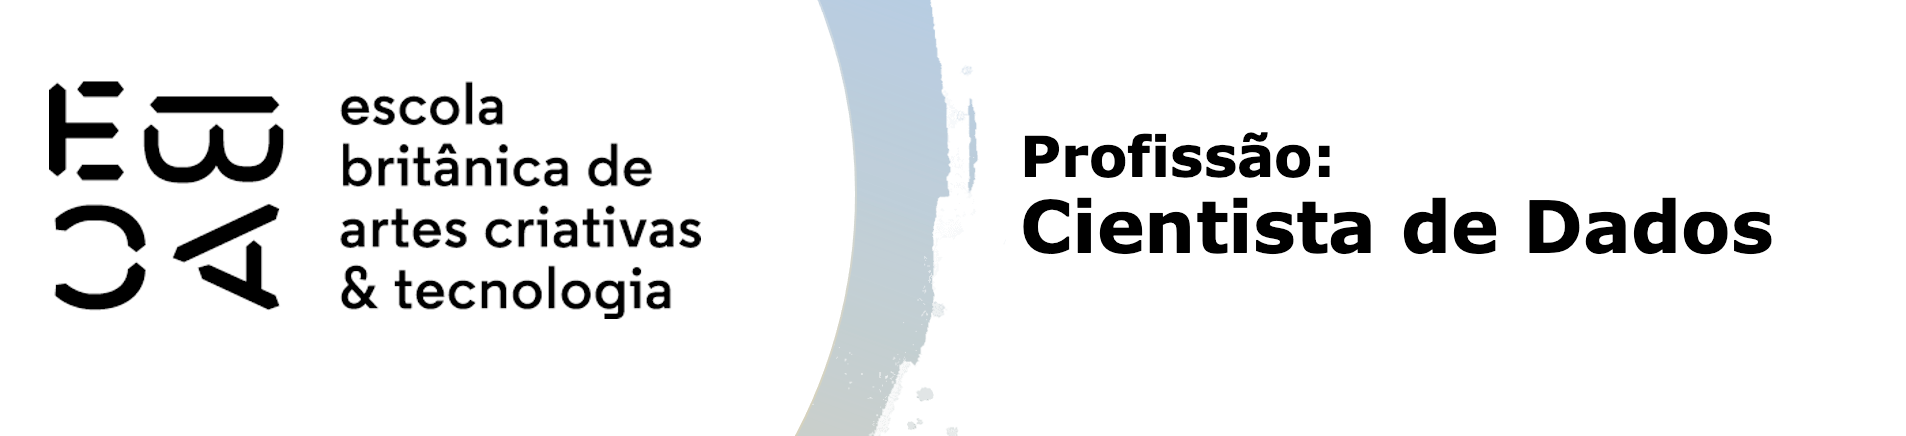

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import t
from scipy.stats import ks_2samp

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics

df = pd.read_feather('credit_scoring.ftr')
df.head(3)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False


In [2]:
#Entendendo os dados:
print("Data máxima: ", df["data_ref"].max())

df.info()

Data máxima:  2016-03-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas

In [3]:
print(df["idade"].nunique(), "valores únicos, valor mínimo de idade: ", df["idade"].min(), ", valor máximo de idade: ", df["idade"].max())
print(df["renda"].nunique(), "valores únicos, valor mínimo de renda: ", df["renda"].min(), ", valor máximo de renda: ", df["renda"].max())

47 valores únicos, valor mínimo de idade:  22 , valor máximo de idade:  68
142419 valores únicos, valor mínimo de renda:  107.67 , valor máximo de renda:  4083986.22


In [4]:
#Substituirei os valores em branco (null) pela média por tipo de renda

df["tempo_emprego"] = df["tempo_emprego"].fillna(df.groupby(["tipo_renda"])["tempo_emprego"].transform("mean"))

In [5]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          750000 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [6]:
# Criando a coluna do mês de referência
df["mes_ref"] = df["data_ref"].dt.strftime("%b/%y")

In [7]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes_ref
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,Jan/15
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,Jan/15
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,Jan/15
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,Jan/15
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,Jan/15


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [8]:
#Dividindo a base de dados, para análise desconsideraremos a data de referência que não tem nenhum significado real para a análise dos dados
oot = df[pd.to_datetime(df.data_ref) > pd.to_datetime(df.data_ref.max()) - pd.DateOffset(months=3)]
train = df[pd.to_datetime(df.data_ref) <= pd.to_datetime(df.data_ref.max()) - pd.DateOffset(months=3)]

In [9]:
# Retirarei a variáel index e data_res, uma vez que elas não tem significado representativo na base de dados que tenha significado para a análise
train = train.drop(["index", "data_ref"], axis = 1)
train.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau', 'mes_ref'],
      dtype='object')

In [10]:
# Retirarei a variáel index e data_res, uma vez que elas não tem significado representativo na base de dados que tenha significado para a análise
oot = oot.drop(["index", "data_ref"], axis = 1)

In [11]:
#Entendimento das bases de estudo
print("Datas presentes na base de desenvolvimento do modelo: ", train["mes_ref"].unique())
print("Datas presentes na base de validação (out of time) do modelo: ", oot["mes_ref"].unique())

Datas presentes na base de desenvolvimento do modelo:  ['Jan/15' 'Feb/15' 'Mar/15' 'Apr/15' 'May/15' 'Jun/15' 'Jul/15' 'Aug/15'
 'Sep/15' 'Oct/15' 'Nov/15' 'Dec/15']
Datas presentes na base de validação (out of time) do modelo:  ['Jan/16' 'Feb/16' 'Mar/16']


In [12]:
df_ = train.drop(["mes_ref"], axis = 1)

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [13]:
# Criar uma tabela descritiva para cada variável com as seguintes atributos: variável, tipo de dado, tipo de variável, número de respostas 
# unitárias, mínimo, máximo, média, moda e respostas menos comum 
des_uni = pd.DataFrame({
    "variavel": df_.columns,
    "dtype": df_.dtypes.astype(str),
    "nmissing": df_.isna().sum().values,
    "valores_unicos": df_.nunique().values
})

des_uni["tipo_var"] = des_uni["dtype"].apply(lambda x: "quantitativo" if any(t in x for t in ["float", "int"]) else "qualitativo")
des_uni["papel"] = des_uni["variavel"].apply(lambda x: "resposta" if x == "mau" else "covariavel")
des_uni["moda"] = des_uni["variavel"].apply(lambda v: df[v].mode().iloc[0] if not df[v].mode().empty else None)
des_uni["menos_comum"] = des_uni["variavel"].apply(lambda v: df[v].value_counts().idxmin() if df[v].nunique() > 0 else None)
des_uni["mínimo"] = des_uni["variavel"].apply(lambda v: round(df[v].min(), 2) if des_uni.loc[des_uni["variavel"] == v, "tipo_var"].item() == "quantitativo" else "-")
des_uni["máximo"] = des_uni["variavel"].apply(lambda v: round(df[v].max(), 2) if des_uni.loc[des_uni["variavel"] == v, "tipo_var"].item() == "quantitativo" else "-")
des_uni["média"] = des_uni["variavel"].apply(lambda v: round(df[v].mean(), 2) if des_uni.loc[des_uni["variavel"] == v, "tipo_var"].item() == "quantitativo" else "-")
des_uni = des_uni.drop(["variavel"], axis = 1)

des_uni

,dtype,nmissing,valores_unicos,tipo_var,papel,moda,menos_comum,mínimo,máximo,média
sexo,object,0,2,qualitativo,covariavel,F,M,-,-,-
posse_de_veiculo,object,0,2,qualitativo,covariavel,N,S,-,-,-
posse_de_imovel,object,0,2,qualitativo,covariavel,S,N,-,-,-
qtd_filhos,int64,0,8,quantitativo,covariavel,0,14,0,14,0.43
tipo_renda,object,0,5,qualitativo,covariavel,Assalariado,Bolsista,-,-,-
educacao,object,0,5,qualitativo,covariavel,Médio,Pós graduação,-,-,-
estado_civil,object,0,5,qualitativo,covariavel,Casado,Viúvo,-,-,-
tipo_residencia,object,0,6,qualitativo,covariavel,Casa,Comunitário,-,-,-
idade,int64,0,47,quantitativo,covariavel,40,22,22,68,43.8
tempo_emprego,float64,0,3005,quantitativo,covariavel,6.928927,25.189041,0.12,42.91,7.61


A primeira observação notada é que há missing valores apenas entre os dados de tempo_emprego.
Notamos que há uma grande variabilidade entre os dados coletados de tempo_emprego e renda. E uma grande quantidade, se destacando em relação às outras, de respostas únicas para essas mesmas variáveis.

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [14]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['woe'].sum(), tab['iv_parcial'].sum()

In [15]:
for var in des_uni[des_uni.papel=="covariavel"].index:
    if  (des_uni.loc[var, "valores_unicos"]>15):
       woe, iv_total = IV(pd.qcut(df[var],q = 10,duplicates='drop'), df.mau)
    else: 
       woe, iv_total  = IV(df[var], df["mau"])
        
    des_uni.loc[var, "woe"] = woe
    des_uni.loc[var, "IV"] = iv_total

des_uni.loc["bom", "dtype"] = "bool"
des_uni.loc["bom", "tipo_var"] = "qualitativo"
des_uni.loc["bom", "papel"] = "resposta"

des_uni

,dtype,nmissing,valores_unicos,tipo_var,papel,moda,menos_comum,mínimo,máximo,média,woe,IV
sexo,object,0.0,2.0,qualitativo,covariavel,F,M,-,-,-,0.036541,0.002185
posse_de_veiculo,object,0.0,2.0,qualitativo,covariavel,N,S,-,-,-,0.004822,0.000108
posse_de_imovel,object,0.0,2.0,qualitativo,covariavel,S,N,-,-,-,-0.062887,0.009693
qtd_filhos,int64,0.0,8.0,quantitativo,covariavel,0,14,0,14,0.43,-2.254980,0.001631
tipo_renda,object,0.0,5.0,qualitativo,covariavel,Assalariado,Bolsista,-,-,-,0.916414,0.009360
educacao,object,0.0,5.0,qualitativo,covariavel,Médio,Pós graduação,-,-,-,-0.093313,0.003547
estado_civil,object,0.0,5.0,qualitativo,covariavel,Casado,Viúvo,-,-,-,-0.098782,0.001126
tipo_residencia,object,0.0,6.0,qualitativo,covariavel,Casa,Comunitário,-,-,-,-0.296875,0.003045
idade,int64,0.0,47.0,quantitativo,covariavel,40,22,22,68,43.8,0.163894,0.020753
tempo_emprego,float64,0.0,3005.0,quantitativo,covariavel,6.928927,25.189041,0.12,42.91,7.61,1.681180,0.315450


Sabemos que variáveis com IV inferior a 0,02 possuem poder preditivo praticamente nulo. Portanto, elas serão desconsideradas nas próximas etapas da análise. São elas:
* sexo
* posse_de_veiculo
* posse_de_imovel
* qtd_filhos
* tipo_renda
* educacao
* estad_civil
* tipo_residencia 

Além disso, observa-se que a variável qt_pessoas_residencia apresentou IV = inf, o que indica separação perfeita entre as classes — ou seja, há categorias que ocorrem exclusivamente em um dos grupos (“bom” ou “mau”). Esse comportamento pode sinalizar problemas de representatividade ou inconsistência nos dados, e por isso a variável deve ser reavaliada, possivelmente por meio de reagrupamento de categorias ou tratamento de outliers.<br>
Observa-se, também, que a variável renda apresenta um IV muito elevado, o que pode indicar risco de sobreajuste (overfitting) ou forte correlação com a variável resposta.<br>
Contudo, considerando que o estudo tem como objetivo analisar a inadimplência de indivíduos, faz sentido manter a variável para avaliação, visto que ela é conceitualmente relevante para o contexto da análise.

In [16]:
des_uni = des_uni.loc[des_uni.index.isin(["idade", "tempo_emprego", "renda", "qt_pessoas_residencia", "mau", "bom"])]
des_uni

,dtype,nmissing,valores_unicos,tipo_var,papel,moda,menos_comum,mínimo,máximo,média,woe,IV
idade,int64,0.0,47.0,quantitativo,covariavel,40,22,22,68,43.8,0.163894,0.020753
tempo_emprego,float64,0.0,3005.0,quantitativo,covariavel,6.928927,25.189041,0.12,42.91,7.61,1.681180,0.315450
qt_pessoas_residencia,float64,0.0,9.0,quantitativo,covariavel,2.0,7.0,1.0,15.0,2.21,inf,inf
renda,float64,0.0,112472.0,quantitativo,covariavel,6193.97,9101.97,107.67,4083986.22,23238.54,5.344578,1.163447
mau,bool,0.0,2.0,qualitativo,resposta,False,True,-,-,-,NaN,NaN
bom,bool,NaN,NaN,qualitativo,resposta,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def biv_discreta(var, df):
    df['bom'] = 1 - df['mau']

    g = df.groupby(var)
    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        'cont': g[var].count()
    }).reset_index()

    # Intervalos de confiança
    biv['ep'] = (biv['mau'] * (1 - biv['mau']) / biv['cont']) ** 0.5
    biv['mau_sup'] = biv['mau'] + t.ppf(0.975, biv['cont'] - 1) * biv['ep']
    biv['mau_inf'] = biv['mau'] - t.ppf(0.975, biv['cont'] - 1) * biv['ep']

    tx_mau_geral = df['mau'].mean()
    woe_geral = np.log(tx_mau_geral / (1 - tx_mau_geral))

    biv['logit'] = np.log(biv['mau'] / (1 - biv['mau']))
    biv['woe'] = biv['logit'] - woe_geral

    biv['iv_parcial'] = ((biv['qt_mau'] / df['mau'].sum()) -
                         (biv['qt_bom'] / df['bom'].sum())) * biv['woe']
    biv['IV_total'] = biv['iv_parcial'].sum()

    print(f"\n🔹 Variável: {var}")
    print(f"📊 IV total: {biv['IV_total'].iloc[0]:.5f}\n")
    print(biv[[var, 'qt_mau', 'qt_bom', 'mau', 'woe', 'iv_parcial']].to_string(index=False))

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].plot(biv[var], biv['woe'], ':bo', label='WOE')
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].set_title(f"WOE de {var}")
    ax[0].legend()

    biv['cont'].plot.bar(ax=ax[1])
    ax[1].set_title("Frequência por categoria")

    plt.tight_layout()
    plt.show()

    return biv

In [18]:
def biv_continua(var, df, ncat=None, bins=None, labels=None):
    df_local = df.copy()
    df_local['bom'] = 1 - df_local['mau']

    # Criar categoria
    if bins is not None:
        df_local['categoria'] = pd.cut(df_local[var], bins=bins, labels=labels, include_lowest=True)
    elif ncat is not None:
        df_local['categoria'], bins = pd.qcut(df_local[var], ncat, retbins=True, precision=0, duplicates='drop')
    else:
        raise ValueError("Você deve fornecer ncat ou bins.")

    g = df_local.groupby('categoria')

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(), 
        var: g[var].mean(), 
        'cont': g[var].count()
    })

    # Intervalos de confiança para mau
    biv['ep'] = (biv['mau'] * (1 - biv['mau']) / biv['cont']) ** 0.5
    biv['mau_sup'] = biv['mau'] + t.ppf(0.975, biv['cont'] - 1) * biv['ep']
    biv['mau_inf'] = biv['mau'] - t.ppf(0.975, biv['cont'] - 1) * biv['ep']

    tx_mau_geral = df_local['mau'].mean()
    woe_geral = np.log(tx_mau_geral / (1 - tx_mau_geral))

    # WOE e IV
    biv['logit'] = np.log(biv['mau'] / (1 - biv['mau']))
    biv['woe'] = biv['logit'] - woe_geral
    biv['iv_parcial'] = ((biv['qt_mau'] / df_local['mau'].sum()) -
                         (biv['qt_bom'] / df_local['bom'].sum())) * biv['woe']
    biv['IV_total'] = biv['iv_parcial'].sum()

    print(f"\n🔹 Variável: {var}")
    print(f"📊 IV total: {biv['IV_total'].iloc[0]:.5f}\n")
    print(biv[[var, 'qt_mau', 'qt_bom', 'mau', 'woe', 'iv_parcial']].to_string(index=False))

    # Gráficos
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].plot(biv[var], biv['woe'], ':bo', label='WOE')
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].set_title(f"WOE de {var}")
    ax[0].legend()
    biv['cont'].plot.bar(ax=ax[1])
    ax[1].set_title("Frequência por categoria")
    plt.tight_layout()
    plt.show()

    return biv

In [19]:
for var in des_uni[(des_uni['papel'] == "covariavel") & (des_uni['tipo_var'] == "qualitativo")].index:
    biv = biv_discreta(var, df_)

Não permaneceram variáveis qualitativas após a primeira exclusão de variáeis considerando-se o IV.

C:\Users\marin\AppData\Local\Temp\ipykernel_41960\3710128451.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: idade
📊 IV total: 0.02210

    idade  qt_mau  qt_bom      mau       woe   iv_parcial
26.637717    4376   48406 0.082907  0.329202 1.102773e-02
29.542461    2205   28835 0.071037  0.161829 1.454996e-03
32.030577    3430   47883 0.066845  0.096491 8.307896e-04
34.479059    2138   31146 0.064235  0.053876 1.648779e-04
36.547225    2171   32736 0.062194  0.019404 2.209162e-05
39.042658    3394   52117 0.061141  0.001209 1.353246e-07
41.496932    1989   32726 0.057295 -0.067847 2.585342e-04
43.467599    1751   30933 0.053574 -0.138945 9.897019e-04
45.997475    2730   44797 0.057441 -0.065148 3.267408e-04
48.443340    1360   25908 0.049875 -0.214376 1.902316e-03
50.934933    2163   41392 0.049661 -0.218900 3.161978e-03
53.945141    2089   37048 0.053377 -0.142838 1.250315e-03
57.028147    2182   35548 0.057832 -0.057951 2.058869e-04
60.353009    2674   44339 0.056878 -0.075598 4.332225e-04
64.526701    1991   29543 0.063138  0.035481 6.720440e-05


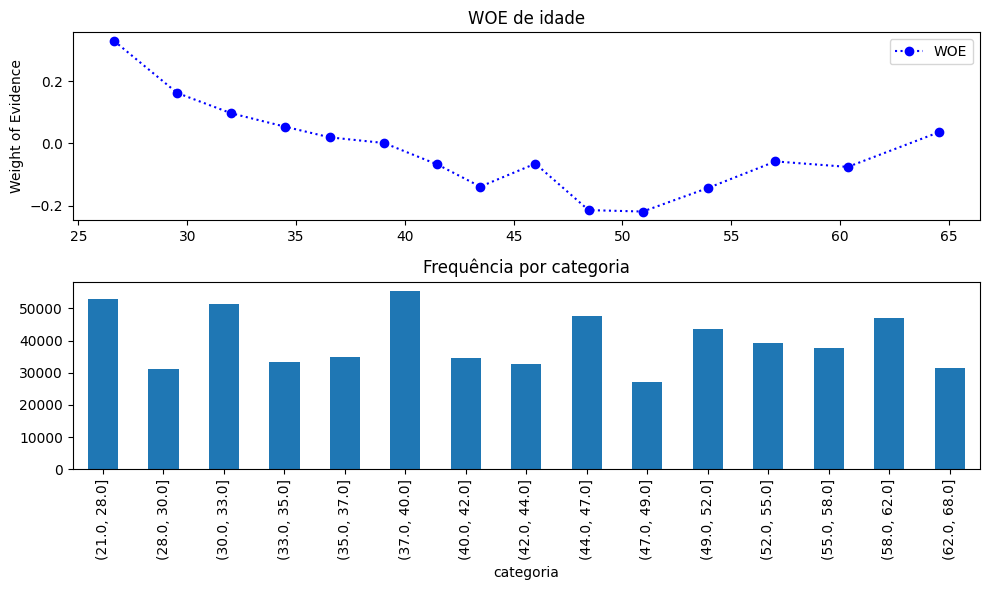

C:\Users\marin\AppData\Local\Temp\ipykernel_41960\3710128451.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: tempo_emprego
📊 IV total: 0.33043

 tempo_emprego  qt_mau  qt_bom      mau       woe  iv_parcial
      0.615761    4484   35620 0.111809  0.660299    0.039051
      1.448620    4011   35974 0.100313  0.538935    0.024578
      2.382094    3518   36421 0.088084  0.395438    0.012400
      3.411688    3303   36703 0.082563  0.324664    0.008113
      4.302716    3060   36946 0.076489  0.241649    0.004332
      5.230738    2767   37195 0.069241  0.134280    0.001274
      6.342904    2286   38028 0.056705 -0.078828    0.000403
      6.927737    6575   96516 0.063779  0.046257    0.000375
      7.177536     849   15827 0.050911 -0.192722    0.000949
      8.082925    1887   38038 0.047264 -0.270906    0.004341
      9.530554    1722   38335 0.042989 -0.370186    0.007794
     11.776839    1176   38825 0.029399 -0.764254    0.028143
     15.469734     704   39260 0.017616 -1.288492    0.065039
     24.703060     301   39669 0.007531 -2.148524    0.133640


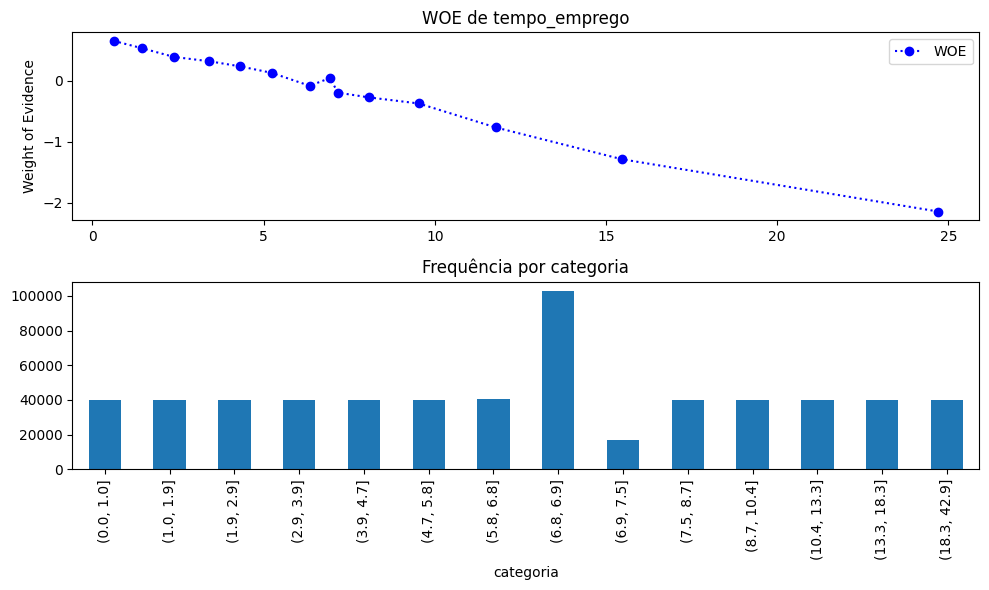

C:\Users\marin\AppData\Local\Temp\ipykernel_41960\3710128451.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: qt_pessoas_residencia
📊 IV total: 0.00126

 qt_pessoas_residencia  qt_mau  qt_bom      mau       woe  iv_parcial
              1.750121   26050  408788 0.059907 -0.020488    0.000301
              3.000000    6803   97323 0.065334  0.072019    0.000929
              4.159447    3790   57246 0.062095  0.017699    0.000032


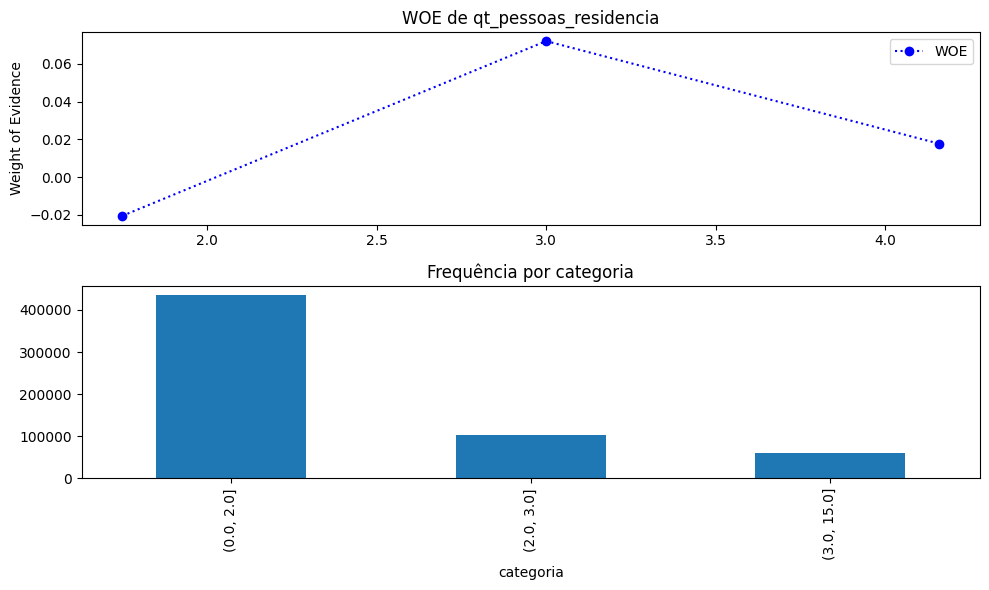

C:\Users\marin\AppData\Local\Temp\ipykernel_41960\3710128451.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: renda
📊 IV total: 1.09797

        renda  qt_mau  qt_bom      mau       woe  iv_parcial
  1176.929450    8066   21934 0.268867  1.732311    0.313876
  2077.711359    4995   25005 0.166500  1.122053    0.103150
  2810.963431    3743   26258 0.124763  0.784608    0.043575
  3533.767329    2995   27007 0.099827  0.533539    0.018031
  4282.345853    2580   27419 0.086003  0.369244    0.008027
  5082.267761    2200   27808 0.073314  0.195825    0.002091
  5953.257972    1896   28096 0.063217  0.036810    0.000069
  6915.681076    1637   28362 0.054568 -0.119494    0.000678
  7994.048992    1433   28567 0.047767 -0.259791    0.003014
  9215.231775    1331   28669 0.044367 -0.337195    0.004912
 10633.834211    1119   28883 0.037298 -0.518127    0.010742
 12262.822292     984   29018 0.032798 -0.651355    0.016059
 14204.316589     837   29159 0.027904 -0.818004    0.023654
 16633.129084     733   29269 0.024432 -0.954447    0.030495
 19774.878134     636   29361 0.021202 -1.099

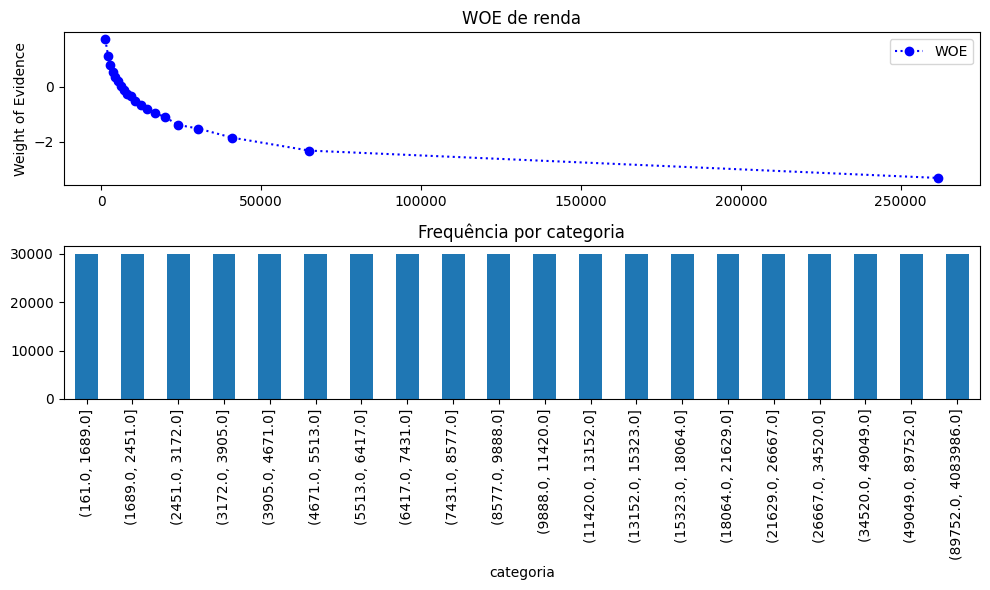

In [20]:
quant_vars = des_uni[(des_uni['papel'] == "covariavel") & (des_uni['tipo_var'] == "quantitativo")].index

for var in quant_vars:
    if (des_uni.loc[var, "valores_unicos"] > 16) & (des_uni.loc[var, "valores_unicos"] < 10001):
        gr = 15
    elif (des_uni.loc[var, "valores_unicos"] > 10000):
        gr = 20
    else:
        gr = des_uni.loc[var, "valores_unicos"]
    gr = int(gr)
    gr = max(gr, 0)  # Ensure non-negative
    biv_continua(var, df_, ncat = gr)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

Por proximidade do valor de woe agruparemos: 
* idade de 30 a 35, 35 a 40, 47 a 52 e 55 a 62
* tempo_emprego 0 a 1.9 e 2,9 a 5,8
  
E os outliers de renda 10793 a 18318, 18318 a 29748 e 29748 a 4083986

C:\Users\marin\AppData\Local\Temp\ipykernel_41960\3710128451.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: idade
📊 IV total: 0.01644

    idade  qt_mau  qt_bom      mau       woe  iv_parcial
27.691740    4329   51653 0.077328  0.253479    0.006705
32.496929    6793   94642 0.066969  0.098482    0.001712
38.079265    5565   84853 0.061547  0.008268    0.000010
43.437269    5579   93822 0.056126 -0.089699    0.001282
49.440624    4414   81934 0.051119 -0.188442    0.004707
53.549708    1513   26953 0.053151 -0.147309    0.000965
58.439569    5432   89982 0.056931 -0.074611    0.000857
63.840093    1522   21804 0.065249  0.070623    0.000200


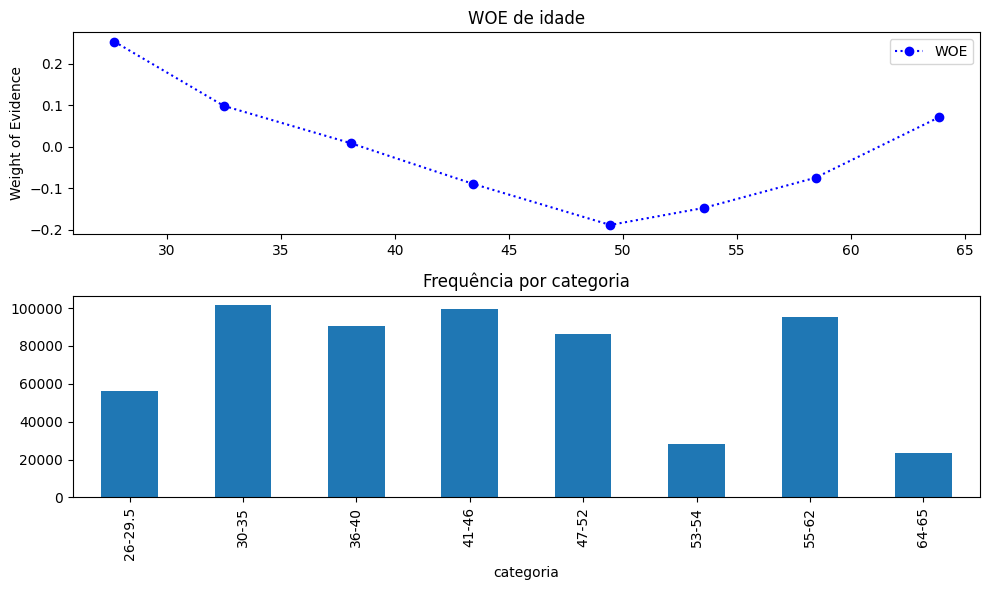

,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,woe,iv_parcial,IV_total
categoria,,,,,,,,,,,,
26-29.5,51653,4329,0.077328,27.691740,55982,0.001129,0.079541,0.075116,-2.479212,0.253479,0.006705,0.016439
30-35,94642,6793,0.066969,32.496929,101435,0.000785,0.068507,0.065431,-2.634209,0.098482,0.001712,0.016439
36-40,84853,5565,0.061547,38.079265,90418,0.000799,0.063114,0.059981,-2.724423,0.008268,0.000010,0.016439
41-46,93822,5579,0.056126,43.437269,99401,0.000730,0.057557,0.054695,-2.822390,-0.089699,0.001282,0.016439
47-52,81934,4414,0.051119,49.440624,86348,0.000749,0.052588,0.049650,-2.921133,-0.188442,0.004707,0.016439
53-54,26953,1513,0.053151,53.549708,28466,0.001330,0.055757,0.050545,-2.880000,-0.147309,0.000965,0.016439
55-62,89982,5432,0.056931,58.439569,95414,0.000750,0.058401,0.055461,-2.807302,-0.074611,0.000857,0.016439
64-65,21804,1522,0.065249,63.840093,23326,0.001617,0.068419,0.062080,-2.662068,0.070623,0.000200,0.016439


In [21]:
bins = [26, 29.5, 35, 40, 46, 52, 54, 62, 65]
labels = [
    "26-29.5",
    "30-35",
    "36-40",
    "41-46",
    "47-52",
    "53-54",
    "55-62",
    "64-65"
]

biv_continua("idade", df = df_, bins = bins, labels = labels)

C:\Users\marin\AppData\Local\Temp\ipykernel_41960\3710128451.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: tempo_emprego
📊 IV total: 0.22570

 tempo_emprego  qt_mau  qt_bom      mau       woe  iv_parcial
      1.038566    8548   72206 0.105852  0.598865    0.062945
      3.858838   12681  148119 0.078862  0.274780    0.022847
      6.777742    8955  135799 0.061864  0.013727    0.000046
      8.183445    3393   69530 0.046529 -0.287353    0.008858
     14.464200    3003  122072 0.024010 -0.972308    0.131003


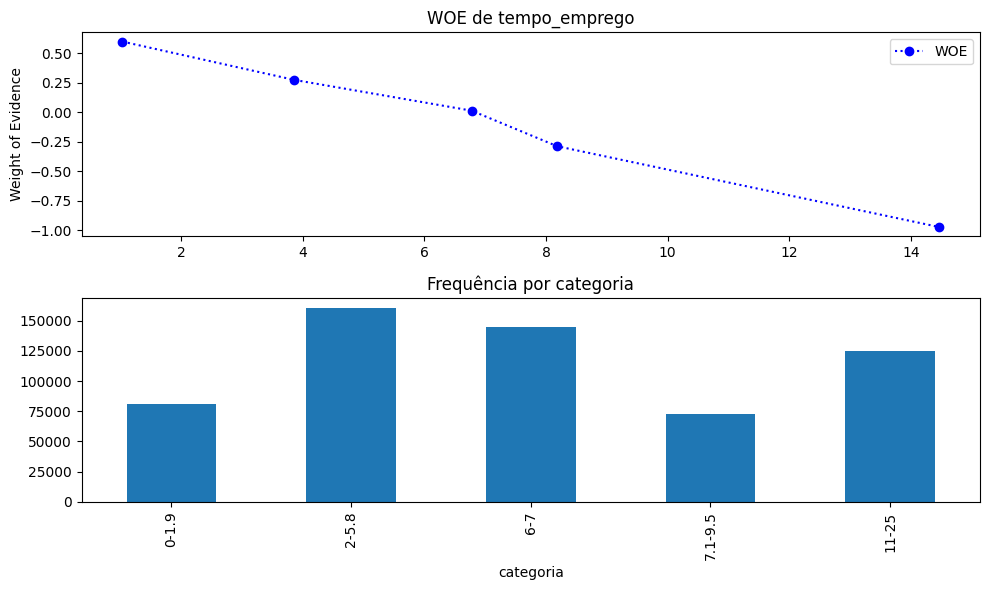

,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,woe,iv_parcial,IV_total
categoria,,,,,,,,,,,,
0-1.9,72206,8548,0.105852,1.038566,80754,0.001083,0.107974,0.103730,-2.133826,0.598865,0.062945,0.225698
2-5.8,148119,12681,0.078862,3.858838,160800,0.000672,0.080179,0.077545,-2.457911,0.274780,0.022847,0.225698
6-7,135799,8955,0.061864,6.777742,144754,0.000633,0.063105,0.060623,-2.718964,0.013727,0.000046,0.225698
7.1-9.5,69530,3393,0.046529,8.183445,72923,0.000780,0.048057,0.045000,-3.020044,-0.287353,0.008858,0.225698
11-25,122072,3003,0.024010,14.464200,125075,0.000433,0.024858,0.023161,-3.704999,-0.972308,0.131003,0.225698


In [22]:
bins_te = [0, 1.9, 5.8, 7.0, 9.5, 25]
labels_te = [
    "0-1.9",
    "2-5.8",
    "6-7",
    "7.1-9.5",
    "11-25"
]
biv_continua("tempo_emprego", df = df_, bins = bins_te, labels = labels_te)

C:\Users\marin\AppData\Local\Temp\ipykernel_41960\3710128451.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: renda
📊 IV total: 1.06860

        renda  qt_mau  qt_bom      mau       woe  iv_parcial
   863.736135    4523    9412 0.324578  1.999881    0.213442
  1483.217994    4009   14377 0.218046  1.455603    0.122106
  2025.951398    3603   17620 0.169769  1.145423    0.076801
  2577.355822    3140   20398 0.133401  0.861477    0.042629
  3168.251863    2808   22577 0.110617  0.648232    0.023696
  3803.644550    2540   24614 0.093541  0.461540    0.011827
  4512.365960    2407   26210 0.084111  0.344931    0.006610
  5316.825491    2119   27976 0.070410  0.152288    0.001244
  6229.539847    1873   29426 0.059842 -0.021646    0.000024
  7283.788727    1656   30305 0.051813 -0.174217    0.001498
  8508.836845    1555   31464 0.047094 -0.274677    0.003685
  9968.267468    1361   32302 0.040430 -0.434218    0.008770
 14088.439322    3023  101142 0.029021 -0.777585    0.075454
 23199.613387    1261   69875 0.017727 -1.282112    0.114903
108507.438516     765  105657 0.007188 -2.195

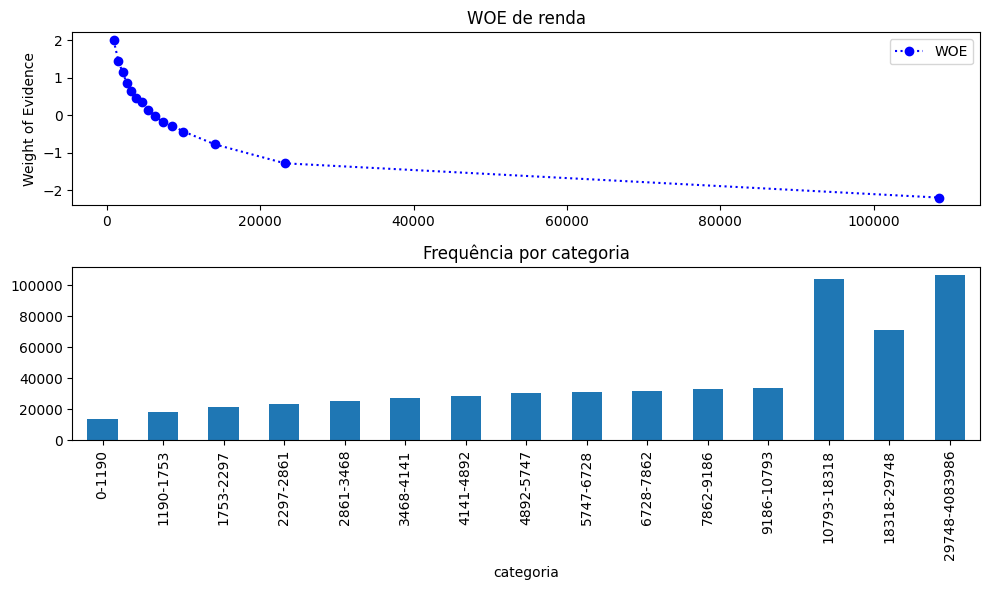

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,woe,iv_parcial,IV_total
categoria,,,,,,,,,,,,
0-1190,9412,4523,0.324578,863.736135,13935,0.003966,0.332353,0.316804,-0.732810,1.999881,0.213442,1.068598
1190-1753,14377,4009,0.218046,1483.217994,18386,0.003045,0.224015,0.212077,-1.277088,1.455603,0.122106,1.068598
1753-2297,17620,3603,0.169769,2025.951398,21223,0.002577,0.174820,0.164717,-1.587268,1.145423,0.076801,1.068598
2297-2861,20398,3140,0.133401,2577.355822,23538,0.002216,0.137745,0.129057,-1.871214,0.861477,0.042629,1.068598
2861-3468,22577,2808,0.110617,3168.251863,25385,0.001969,0.114475,0.106758,-2.084459,0.648232,0.023696,1.068598
3468-4141,24614,2540,0.093541,3803.644550,27154,0.001767,0.097004,0.090077,-2.271151,0.461540,0.011827,1.068598
4141-4892,26210,2407,0.084111,4512.365960,28617,0.001641,0.087327,0.080895,-2.387760,0.344931,0.006610,1.068598
4892-5747,27976,2119,0.070410,5316.825491,30095,0.001475,0.073301,0.067520,-2.580403,0.152288,0.001244,1.068598
5747-6728,29426,1873,0.059842,6229.539847,31299,0.001341,0.062470,0.057214,-2.754337,-0.021646,0.000024,1.068598


In [23]:
bins_renda = [
    0,     
    1190,
    1753, 
    2297,
    2861, 
    3468, 
    4141, 
    4892, 
    5747, 
    6728, 
    7862, 
    9186, 
    10793,    
    18318,    
    29748,    
    4083986   
]

labels_renda = [
    "0-1190", 
    "1190-1753", 
    "1753-2297", 
    "2297-2861", 
    "2861-3468", 
    "3468-4141", 
    "4141-4892", 
    "4892-5747", 
    "5747-6728",
    "6728-7862",
    "7862-9186",
    "9186-10793",
    "10793-18318",
    "18318-29748",
    "29748-4083986"
]


biv_continua("renda", df = df_, bins = bins_renda, labels = labels_renda)

In [24]:
# Equação preditiva proposta 
# Primeiro analisarei uma fórmula simples
formula = '''
    mau ~ idade + tempo_emprego  + renda + qt_pessoas_residencia
'''

rl = smf.glm(formula, data=df_, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599995
Model Family:                         Binomial   Df Model:                            4
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2493e+05
Date:                         Sun, 05 Oct 2025   Deviance:                   2.4985e+05
Time:                                 22:43:58   Pearson chi2:                 1.87e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04246
Covariance Type:                     nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.5806      0.030     52.677      0.000       1.522       1.639
idade                     0.0004      0.001      0.746      0.456      -0.001       0.001
tempo_emprego             0.0227      0.002     12.823      0.000       0.019       0.026
renda                     0.0001   1.08e-06     95.871      0.000       0.000       0.000
qt_pessoas_residencia     0.0018      0.006      0.294      0.769      -0.010       0.014
=========================================================================================
"""

In [25]:
# Pelos gráficos observados anteriormente percebmos que idade tem uma forma semalhante a uma equação concava de 2º grau, tempo_emprego uma equação inversa linear, qt_emprego_residencia convexa de 2º grau e em
# relação a renda uma hibérbole positiva
formula = '''
    mau ~ I(idade**2) + tempo_emprego + I(1/renda) + I(qt_pessoas_residencia**2)
'''

rl = smf.glm(formula, data=df_, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599995
Model Family:                         Binomial   Df Model:                            4
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2475e+05
Date:                         Sun, 05 Oct 2025   Deviance:                   2.4951e+05
Time:                                 22:44:00   Pearson chi2:                 5.92e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04301
Covariance Type:                     nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.9191      0.018    166.069      0.000       2.885       2.954
I(idade ** 2)                 -4.143e-05   5.83e-06     -7.106      0.000   -5.29e-05      -3e-05
tempo_emprego                     0.0685      0.001     46.030      0.000       0.066       0.071
I(1 / renda)                  -2083.1445     16.611   -125.410      0.000   -2115.701   -2050.588
I(qt_pessoas_residencia ** 2)    -0.0014      0.001     -1.400      0.162      -0.003       0.001
=================================================================================================
"""

In [36]:
# Considerando os valores dos primeiros modelos excluirei da fórmula qt_pessoas_residencia por ter valor de p muito alto em ambas os resultados
formula = '''
    mau ~ I(idade**2) + I(-tempo_emprego) + I(1/renda) 
'''

rl = smf.glm(formula, data=df_, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599996
Model Family:                         Binomial   Df Model:                            3
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2476e+05
Date:                         Sun, 05 Oct 2025   Deviance:                   2.4951e+05
Time:                                 23:01:37   Pearson chi2:                 5.92e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04301
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.9070      0.015    190.181      0.000       2.877       2.937
I(idade ** 2)     -3.923e-05   5.61e-06     -6.989      0.000   -5.02e-05   -2.82e-05
I(-tempo_emprego)    -0.0684      0.001    -46.016      0.000      -0.071      -0.065
I(1 / renda)      -2083.1417     16.611   -125.410      0.000   -2115.698   -2050.586
=====================================================================================
"""

Foram testados trÊs modelos de regressão logística com o objetivo de avaliar o impacto das variáveis idade, tempo de emprego, renda e quantidade de pessoas na residência sobre a probabilidade de inadimplência. O primeiro modelo considerou as variáveis em sua forma original, enquanto o segundo aplicou transformações não lineares (idade², 1/renda e qt_pessoas_residencia²), visando capturar relações mais complexas entre os preditores e a variável resposta.

Os segundo modelo apresentou melhor ajuste estatístico, com redução na deviance (de 2.4985e+05 para 2.4951e+05) e aumento do Pseudo R² de 0.04246 para 0.04301, indicando leve melhora na explicação da variância da resposta. Além disso, as variáveis transformadas (idade², tempo_emprego e 1/renda) mostraram-se altamente significativas (p < 0.001), sugerindo que essas relações não lineares descrevem melhor o comportamento dos dados.

Por outro lado, a variável qt_pessoas_residencia, mesmo após a transformação quadrática, não apresentou significância estatística (p = 0.162) e seu impacto sobre o ajuste do modelo foi nulo. A exclusão dessa variável resultou em um modelo final mais parcimonioso, mantendo o mesmo nível de ajuste (Pseudo R² = 0.04301) e a mesma log-verossimilhança, mas com menor complexidade.

Em síntese, o modelo final — composto por idade², tempo de emprego e renda (1/renda) — mostrou-se estatisticamente robusto, coerente com a teoria e mais eficiente, representando a melhor alternativa entre os testados. A relação entre as variáveis e a inadimplência manteve-se economicamente plausível: quanto maior a renda e o tempo de emprego, menor a probabilidade de inadimplência, enquanto a idade apresentou uma relação não linear, sugerindo que o risco é maior em faixas etárias intermediárias.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [37]:
oot['score'] = rl.predict(oot)

# Acurácia
acc = metrics.accuracy_score(oot.mau, oot.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(oot.mau, oot.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(oot.loc[oot.mau == 1, 'score'], oot.loc[oot.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 14.5% 
AUC: 26.7% 
GINI: -46.6%
KS: 33.8%


Apesar da consistência estatística, as métricas de desempenho preditivo indicam baixa capacidade discriminatória. O modelo final apresentou acurácia de 14,5%, AUC de 26,7% e índice de Gini negativo (-46,6%), sugerindo que o modelo está classificando de forma inversa em relação à realidade observada. O KS (Kolmogorov–Smirnov) de 33,8% demonstra alguma separação entre bons e maus pagadores, porém ainda insuficiente para caracterizar um bom poder preditivo.

Esses resultados indicam que, embora o modelo esteja estatisticamente ajustado e teoricamente coerente, sua performance preditiva é insatisfatória, demandando ajustes adicionais — como revisão de variáveis explicativas, novos tratamentos de outliers ou o uso de técnicas não lineares mais robustas (como árvores de decisão ou modelos de ensemble) para capturar padrões mais complexos nos dados.